# Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [2]:
#Dependencies to load the dataset in tf.data format
!pip install med_dataloader==0.1.12 -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.8 MB/s eta 0:00:00


In [3]:
pip install seaborn

In [4]:
#Link colab to the directories of a given google drive account
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH)

Mounted at /content/gdrive


In [5]:
ROOT_PATH

'/content/gdrive'

In [6]:
#Possible usefull dependencies
import med_dataloader as mdl
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model
import keras

from datetime import datetime
from dateutil.tz import gettz
import SimpleITK as sitk

import scipy
import cv2

import SimpleITK as sitk
import imageio
import re
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix
import pickle
import warnings
warnings.filterwarnings("ignore")

In [7]:
WD_PATH = os.path.join(ROOT_PATH, 'MyDrive', 'PROJECT_NEURO')

DATASET_PATH = os.path.join(WD_PATH, 'Dataset_GS') #Move the folder containig dataset (e.g. Dataset_SP) into WD_PATH

MODELS_PATH = os.path.join(WD_PATH, 'Models') #Folder where best trained models will be saved

if not os.path.exists(MODELS_PATH): #si può togliere
    os.mkdir(MODELS_PATH)


# Data Loader

In [8]:
NUM_CLASSES=7
seed=42

X_train_denoised=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/Processed_X/X_train_denoised.npy')
y_train=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/y/y_train.npy')
X_val_denoised=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/Processed_X/X_val_denoised.npy')
X_test_denoised=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/Processed_X/X_test_denoised.npy')
y_val=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/y/y_val.npy')
y_test=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/y/y_test.npy')


## Performance function

In [23]:
def performance(X_denoised,y_val,model,PRINT=True,RETURN=False):

  classes=['Background and vocal tract','Upper lip','Hard palate','Soft palate','Tongue','Lower lip','Head']
  #POSTPROCESSING
  y_pred=model.predict(X_denoised) #(N,256,256,7) prediction of the model expressed as probabilities
  y_pred_array=np.argmax(y_pred,axis=-1) #(N,256,256) prediction of the model expressed as class index
  y_pred_one_hot=np.stack([(y_pred_array == level).astype(int) for level in np.linspace(0, 6, 7)], axis=-1) #(N,256,256,7) predicted binary masks for each class
  y_pred_flat = y_pred_one_hot.reshape(-1, 7) #(Nx256x256,7) predicted binary array for each class
  y_pred_argmax = np.argmax(y_pred_flat, axis=1) #(Nx256x256) one vector with position of the max for each pixel but flatten

  y_val_flat = y_val.reshape(-1, 7) #(Nx256x256,7) ground truth expressed as vector for each class
  y_val_argmax = np.argmax(y_val_flat, axis=1) #(Nx256x256) one vector with the position of the the max numbers as ground truth


  #Mean_DICE without argmax
  mean_dice_metric = Mean_DICE(NUM_CLASSES)
  mean_dice_metric.update_state(y_pred, y_val)
  mean_dice_without_argmax=mean_dice_metric.result().numpy()

  #Mean_DICE with argmax
  mean_dice_metric = Mean_DICE(NUM_CLASSES)
  mean_dice_metric.update_state(y_pred_one_hot, y_val)
  mean_dice_with_argmax=mean_dice_metric.result().numpy()

  #DICE for each class
  dice_class=np.array(Mean_DICE_class(7).compute(y_pred_one_hot,y_val))
  dice_class=np.mean(dice_class,axis=-1)

  #Mean_IoU without argmax
  mean_IoU=tfk.metrics.MeanIoU(num_classes=NUM_CLASSES)
  mean_IoU.update_state(y_pred, y_val)
  mean_IoU_without_argmax=mean_IoU.result().numpy()

  #Mean_IoU with argmax
  mean_IoU.update_state(y_pred_one_hot, y_val)
  mean_IoU_with_argmax=mean_IoU.result().numpy()

  #Accuracy
  accuracy = accuracy_score(y_val_argmax, y_pred_argmax)

  #Precision
  precision_per_class=precision_score(y_val_argmax, y_pred_argmax, average=None)
  precision_macro=precision_score(y_val_argmax, y_pred_argmax, average='macro') #con average=None restituisce la lista con precision per ogni classe
  precision_weighted=precision_score(y_val_argmax, y_pred_argmax, average='weighted')

  #Recall
  recall_per_class=recall_score(y_val_argmax, y_pred_argmax, average=None)
  recall_macro=recall_score(y_val_argmax, y_pred_argmax, average='macro')
  recall_weighted=recall_score(y_val_argmax, y_pred_argmax, average='weighted')

  # Confusion matrix
  conf_matrix = confusion_matrix(y_val_argmax,y_pred_argmax)
  conf_matrix_norm=conf_matrix/sum(conf_matrix) #normalize to obtain frequencies

  if PRINT:
    print('mean_dice_metric_without_argmax: ', mean_dice_without_argmax)
    print('mean_dice_metric_with_argmax: ', mean_dice_with_argmax)
    print('mean_IoU_without_argmax: ',mean_IoU_without_argmax)
    print('mean_IoU_with_argmax: ',mean_IoU_with_argmax)
    print('accuracy: ',accuracy)
    print('precision_macro: ',precision_macro)
    print('precision_weighted: ',precision_weighted)
    print('recall_macro: ',recall_macro)
    print('recall_weighted: ',recall_weighted)

    for i in range(7):
      print('\nClass: ',classes[i],' (',i,'):')
      print('DICE: ',dice_class[i])
      print('Precision: ',precision_per_class[i])
      print('Recall: ',recall_per_class[i])

    plt.figure(figsize=(10,10))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    if RETURN:
      return (mean_dice_without_argmax,mean_dice_with_argmax,mean_IoU_without_argmax,mean_IoU_with_argmax,accuracy,precision_per_class,precision_macro,precision_weighted,recall_per_class,recall_macro,recall_weighted,conf_matrix_norm)
    else:
      return

## Weighted cross-entropy
we define a different loss function that weight the loss depending on the label. We made this choice in order to increase the impact of underrepresented classes (es. upper lip)

In [10]:
class_elements = {}
class_weights = {}
for class_index in range(NUM_CLASSES):
    class_elements[class_index] = 0
    class_weights[class_index] = 0.0

for train_index in range(len(y_train)):
    image = y_train[train_index,:,:,:]
    for class_index in range(NUM_CLASSES):
        class_elements[class_index] += np.sum(image[:,:,class_index] == 1)

for class_index in class_weights.keys():
    class_weights[class_index] = sum(class_elements.values()) / (NUM_CLASSES * class_elements[class_index])


def weighted_cross_entropy(class_weights,NUM_CLASSES=7):
    def loss(y_true, y_pred):
        if len(y_pred.shape) == 4:
            axis = (1, 2)
        elif len(y_pred.shape) == 5:
            axis = (1, 2, 3)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        loss_image = 0.0
        loss_ce = 0.0
        for c in range(NUM_CLASSES):
            loss_image = tf.math.add(-1*(tf.math.reduce_mean(tf.math.multiply(class_weights[c]*y_true[:,:,:,c], tf.math.log(y_pred[:,:,:,c]+1e-9)), axis=axis)), loss_image)
        loss_ce = tf.math.reduce_mean(loss_image)
        return loss_ce
    return loss

## Mean DICE
 $\, DICE = \frac{1}{C}  \sum_{c = 1}^{C} \frac{2 \lvert S_g^c \cap S_p^c \rvert}{\lvert S_g^c \rvert + \lvert S_p^c \rvert} = \frac{2\,\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c\,p_i^c}{\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c \,+\, \sum_{c=1}^{C}\sum_{i=1}^{N}p_i^c  } \quad$ [[3]](https://bmcmedimaging.biomedcentral.com/track/pdf/10.1186/s12880-015-0068-x.pdf)

In [11]:
class Mean_DICE(tf.keras.metrics.Metric):
    def __init__(self,
                 num_classes,
                 name='Mean_DICE',
                 smooth_factor = 1e-9,
                 **kwargs):

        super().__init__(name = name, **kwargs)
        self.num_classes = num_classes
        self.axis = None
        self.smooth_factor = smooth_factor

    def update_state(self, y_true, y_pred, sample_weight=None):

        num_classes = self.num_classes
        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        dice_classes = 0.0
        dice_image = 0.

        if len(y_pred.shape) == 4:
            self.axis = (1,2)
        elif len(y_pred.shape) == 5:
            self.axis = (1,2,3)

        for c in range(num_classes):

            abs_label = tf.math.reduce_sum(y_true[...,c], axis = self.axis )
            abs_pred = tf.math.reduce_sum(y_pred[...,c], axis = self.axis )
            MD_batch_denom = tf.math.add(tf.math.add(abs_label, abs_pred), self.smooth_factor)
            MD_batch_num = tf.math.add(2*tf.math.reduce_sum(tf.math.multiply(y_true[...,c], y_pred[...,c]), axis = self.axis), self.smooth_factor)
            dice_image = tf.math.divide(MD_batch_num, MD_batch_denom)
            dice_classes = tf.math.add(dice_image, dice_classes)

        self.mean_dice = tf.math.divide(dice_classes, num_classes)
        self.mean_dice = tf.math.reduce_mean(self.mean_dice)

    def result(self):
        return self.mean_dice

    def get_config(self):
        config = super().get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @ classmethod
    def from_config(cls, config):
        return cls(**config)


In [12]:
class Mean_DICE_class():
    def __init__(self,
                 num_classes,
                 name='Mean_DICE',
                 smooth_factor = 1e-9,
                 **kwargs):

        self.num_classes = num_classes
        self.axis = None
        self.smooth_factor = smooth_factor

    def compute(self, y_true, y_pred, sample_weight=None):

        num_classes = self.num_classes
        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        dice_classes = 0.0
        dice_image = 0.
        dice_c=[]
        if len(y_pred.shape) == 4:
            self.axis = (1,2)
        elif len(y_pred.shape) == 5:
            self.axis = (1,2,3)

        for c in range(num_classes):

            abs_label = tf.math.reduce_sum(y_true[...,c], axis = self.axis )
            abs_pred = tf.math.reduce_sum(y_pred[...,c], axis = self.axis )
            MD_batch_denom = tf.math.add(tf.math.add(abs_label, abs_pred), self.smooth_factor)
            MD_batch_num = tf.math.add(2*tf.math.reduce_sum(tf.math.multiply(y_true[...,c], y_pred[...,c]), axis = self.axis), self.smooth_factor)
            dice_image = tf.math.divide(MD_batch_num, MD_batch_denom)
            dice_c.append(dice_image)
            dice_classes = tf.math.add(dice_image, dice_classes)

        self.mean_dice = tf.math.divide(dice_classes, num_classes)
        self.mean_dice = tf.math.reduce_mean(self.mean_dice)
        return dice_c

# Train-val trend
better representation of the training-validation curves

In [ ]:
file_path = '/content/gdrive/MyDrive/PROJECT_NEURO/AAA_SCRIPT_DEFINITIVI/model_history.pkl'
with open(file_path, 'rb') as pickle_file:
    a = pickle.load(pickle_file)

print(f"Dictionary loaded from {file_path}")

Dictionary loaded from /content/gdrive/MyDrive/PROJECT_NEURO/AAA_SCRIPT_DEFINITIVI/model_history.pkl


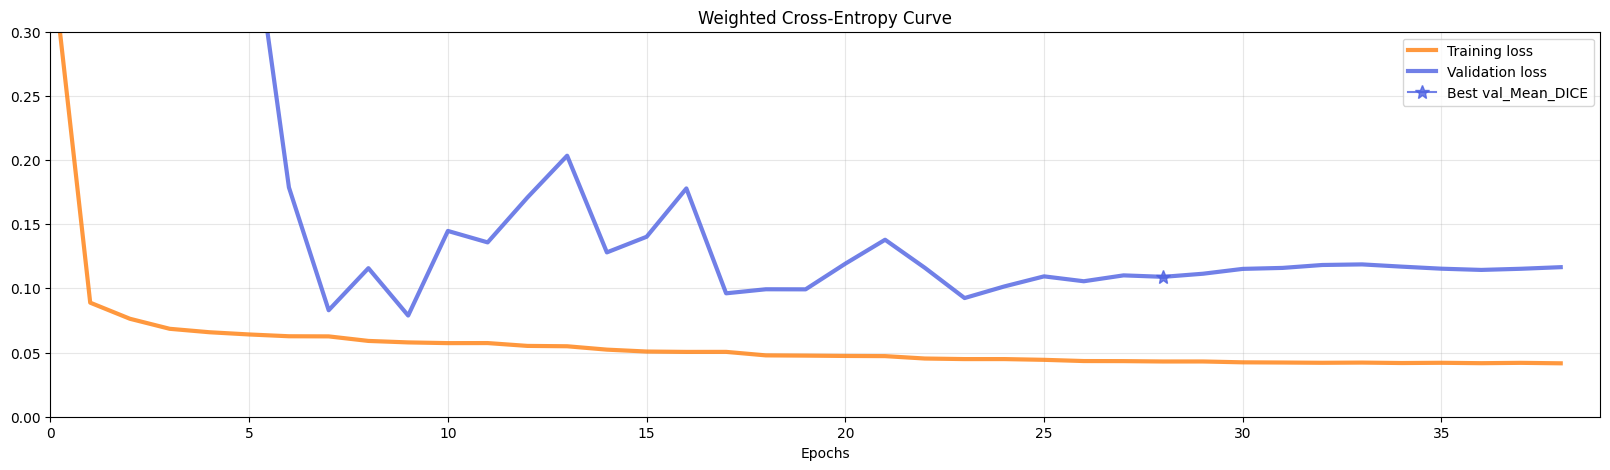

In [ ]:
metrica_max = 'val_Mean_DICE'
best_epoch = np.argmax(a[metrica_max])  # epoch with the highest validation accuracy
#loss
metrica='loss'
metrica_val='val_loss'
plt.figure(figsize=(20, 5))
plt.plot(a[metrica], label=f'Training {metrica}', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(a[metrica_val], label=f'Validation {metrica}', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, a[metrica_val][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2', label=f'Best {metrica_max}')
plt.legend(loc='upper right')
plt.title('Weighted Cross-Entropy Curve')
plt.xlabel('Epochs')
plt.grid(alpha=0.3)
plt.ylim([0,0.3])
plt.xlim([0,len(a[metrica])])
plt.show()

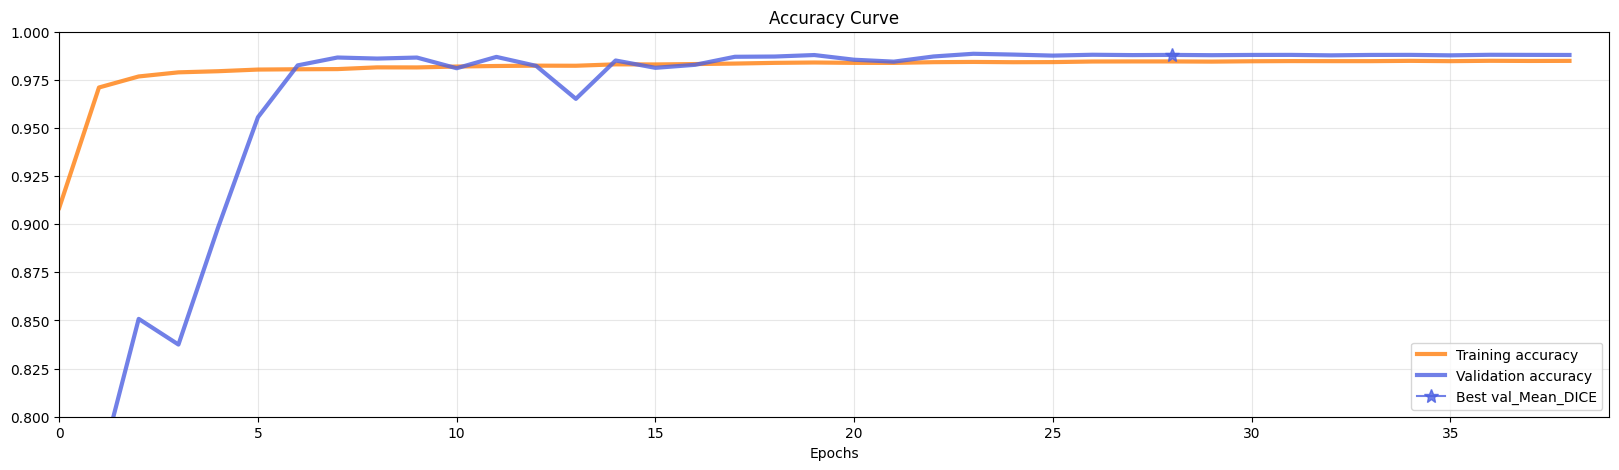

In [ ]:
metrica_max = 'val_Mean_DICE'
best_epoch = np.argmax(a[metrica_max])  # epoch with the highest validation accuracy
#accuracy
metrica='accuracy'
metrica_val='val_accuracy'
plt.figure(figsize=(20, 5))
plt.plot(a[metrica], label=f'Training {metrica}', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(a[metrica_val], label=f'Validation {metrica}', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, a[metrica_val][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2', label=f'Best {metrica_max}')
plt.legend(loc='lower right')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.grid(alpha=0.3)
plt.ylim([0.8,1])
plt.xlim([0,len(a[metrica])])
plt.show()

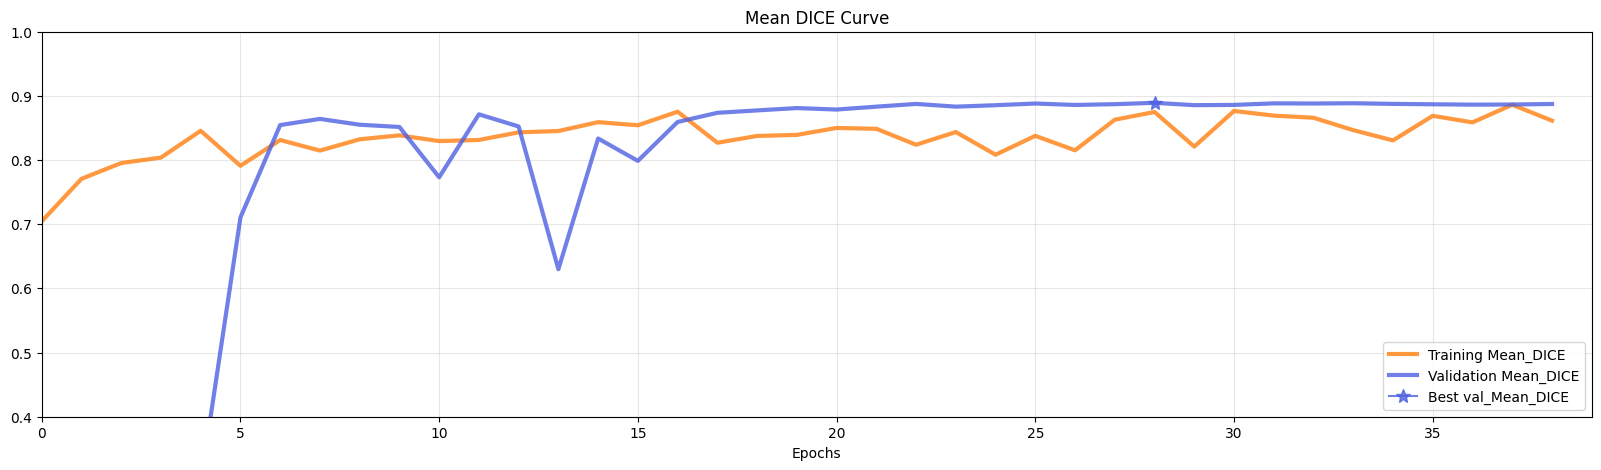

In [ ]:
metrica_max = 'val_Mean_DICE'
best_epoch = np.argmax(a[metrica_max])  # epoch with the highest validation accuracy
#loss
metrica='Mean_DICE'
metrica_val='val_Mean_DICE'
plt.figure(figsize=(20, 5))
plt.plot(a[metrica], label=f'Training {metrica}', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(a[metrica_val], label=f'Validation {metrica}', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, a[metrica_val][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2', label=f'Best {metrica_max}')
plt.legend(loc='lower right')
plt.title('Mean DICE Curve')
plt.xlabel('Epochs')
plt.grid(alpha=0.3)
plt.ylim([0.4,1])
plt.xlim([0,len(a[metrica])])
plt.show()

#Test prediction

In [13]:
model=tf.keras.models.load_model('gdrive/MyDrive/PROJECT_NEURO/AAA_SCRIPT_DEFINITIVI/MODELLO_DEFINITIVO', custom_objects={'Mean_DICE': Mean_DICE, 'loss': weighted_cross_entropy})

3/3 [==============================] - 2s 762ms/step
mean_dice_metric_without_argmax:  0.88786805
mean_dice_metric_with_argmax:  0.8934363
mean_IoU_without_argmax:  0.82591283
mean_IoU_with_argmax:  0.9043883
accuracy:  0.9873580013413027
precision_macro:  0.8392677642580784
precision_weighted:  0.9880962885580699
recall_macro:  0.9704318924802918
recall_weighted:  0.9873580013413027

Class:  Background and vocal tract  ( 0 ):
DICE:  0.99320376
Precision:  0.993834889392504
Recall:  0.9925713960189964

Class:  Upper lip  ( 1 ):
DICE:  0.82265884
Precision:  0.7126765599856965
Recall:  0.9769607843137255

Class:  Hard palate  ( 2 ):
DICE:  0.81311345
Precision:  0.7115296014743147
Recall:  0.9553819981441386

Class:  Soft palate  ( 3 ):
DICE:  0.7634279
Precision:  0.6366832250668705
Recall:  0.9610104971738378

Class:  Tongue  ( 4 ):
DICE:  0.9474946
Precision:  0.9241775032857128
Recall:  0.9720492706062173

Class:  Lower lip  ( 5 ):
DICE:  0.9404319
Precision:  0.9153013360602894
Rec

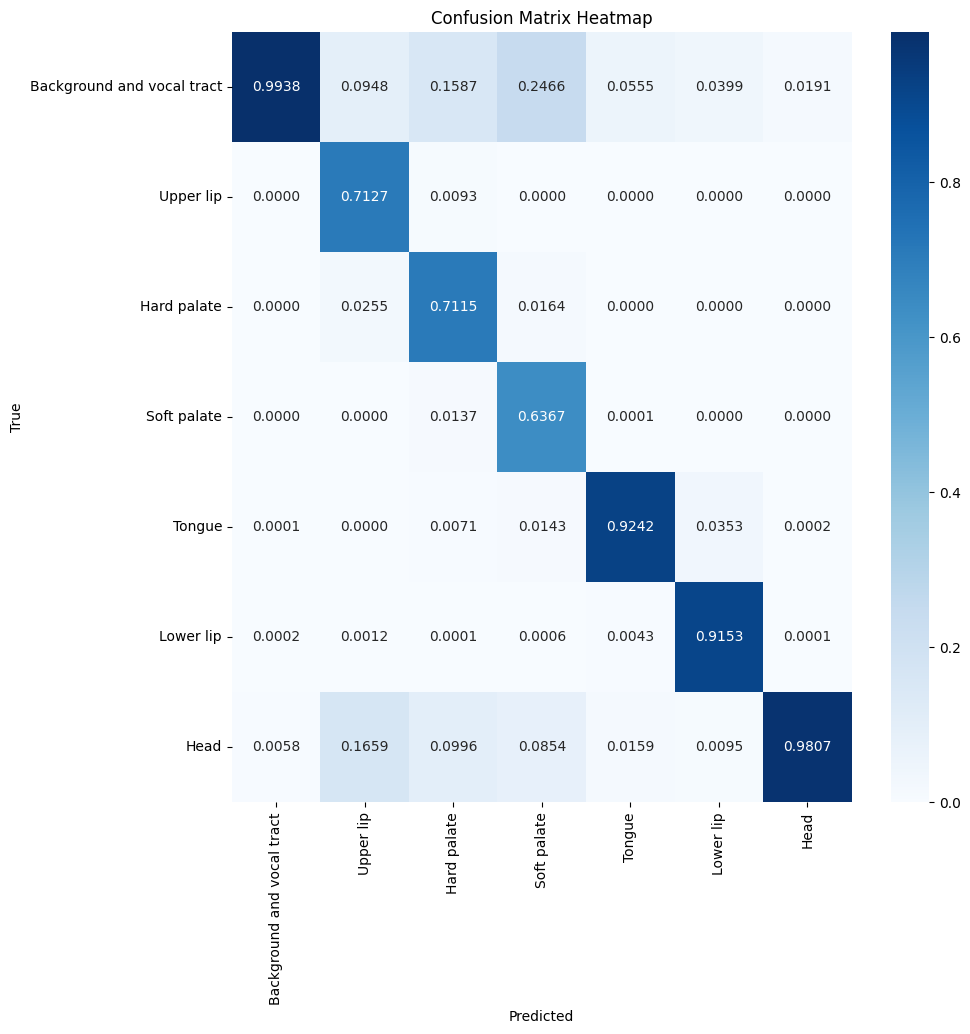

In [24]:
performance(X_test_denoised,y_test,model)